---
title: "2. Embeddings"
image: "disaster.jpeg"
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
---

# 2. Embeddings

In the last notebook we use only the TextVectorization layer to represent text. I think it is not efficient because each position on each sentence will have a different number(index) depending on the token associated to it but the same weight! So we are sharing weights between words without capture some context.

It could be better if we encode each word as a vector(wich have magnitude and direction). So we could represent similar words with the magnitud and direction of the vectors! One way to do this is for example computing the (cosine similarity)[https://en.wikipedia.org/wiki/Cosine_similarity]

We will do that with Embeddings! This is a vector that represent in this case a token! (It could be represent a letter, sub-word, sentence, etc.)

We can use the (Tensorflow Embedding layer)[https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding] for this. This will initialize the representations by random (see the parameter `embedding_initializer`). So the idea is fit these embeddings to the data and so learn to represent text. 

We can also use pre-trained Embeddings like (Glove)[https://nlp.stanford.edu/projects/glove/] or (Word2Vec)[https://jalammar.github.io/illustrated-word2vec/]. This could be a better idea because we can fine-tune those. 

In this notebook we will do both (Embedding And Pre-trained Embeddings).

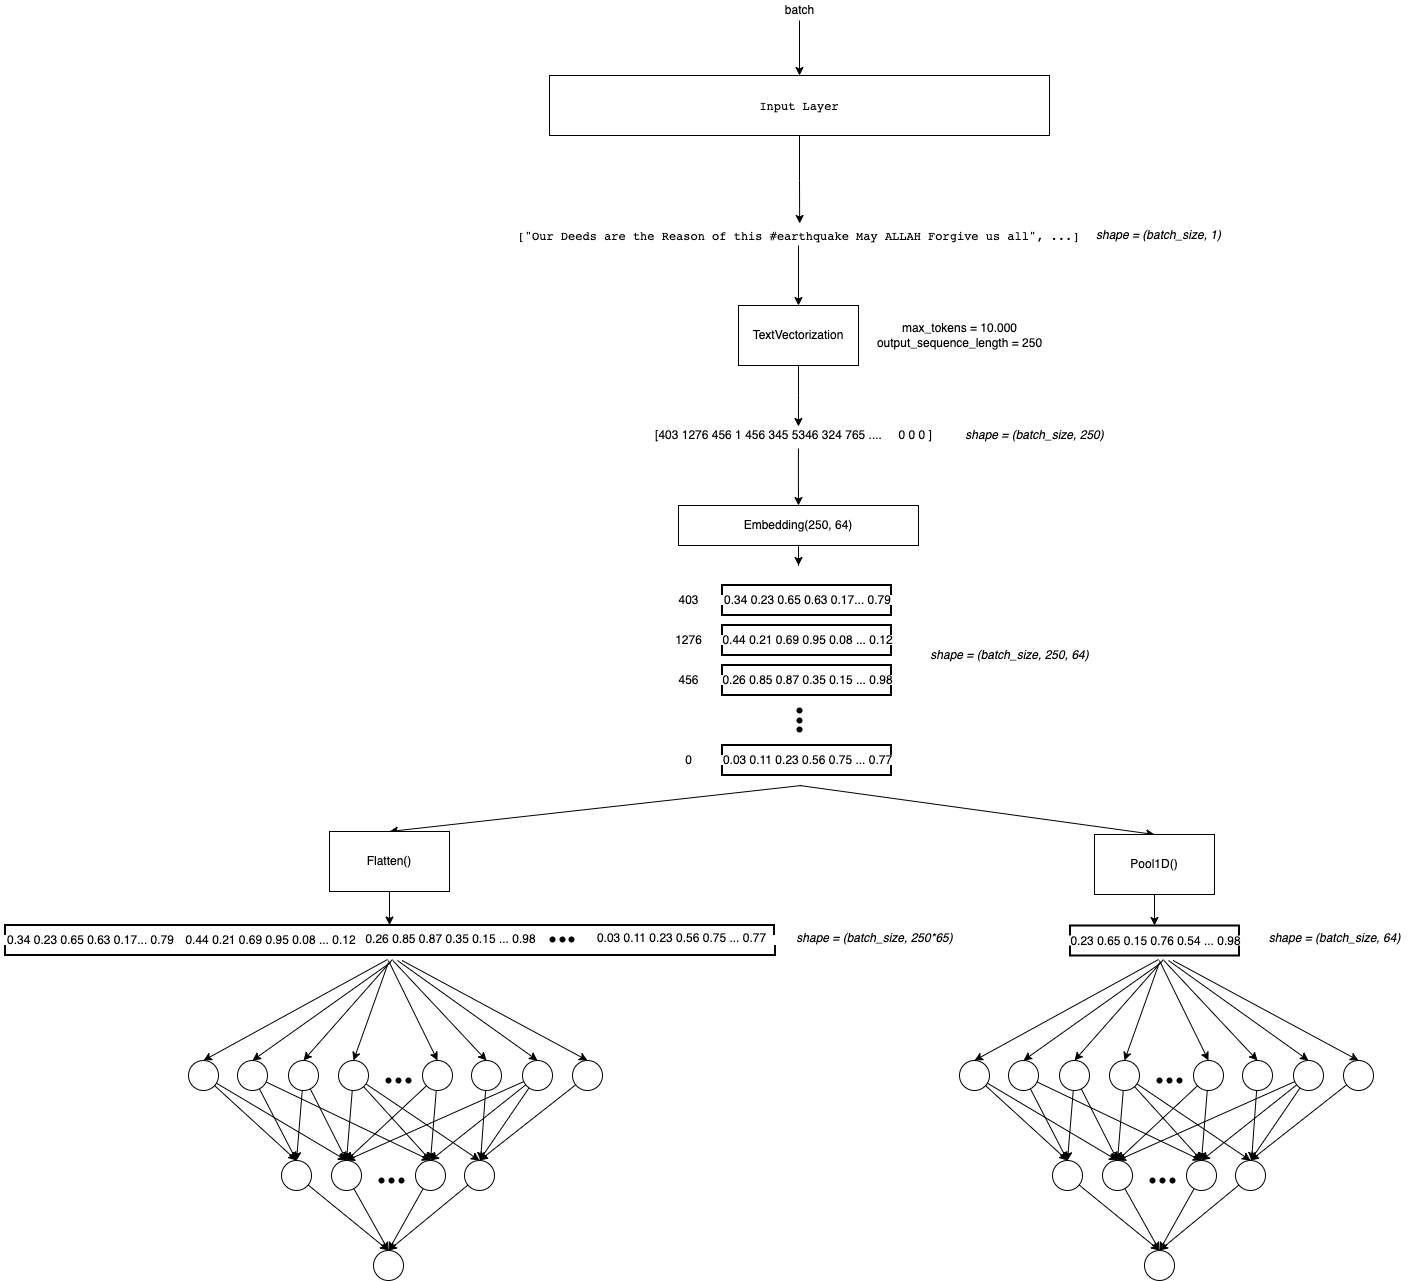

> Remember that this belong to a NLP Notebook series where I am learning and testing different NLP approachs in this competition. Like NN, Embedding, RNN, Transformers, HuggingFace, etc.

> To see the other notebooks visit: https://www.kaggle.com/code/diegomachado/seqclass-nn-embed-rnn-lstm-gru-bert-hf

### Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import gc


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Lambda
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow_hub as hub
#import tensorflow_text as text # Bert preprocess uses this 
from tensorflow.keras.optimizers import Adam

import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors

#nltk.download('stopwords')

## Data

In [2]:
# Load data
train = pd.read_csv("/kaggle/input/df-split/df_split/df_train.csv")
test = pd.read_csv("/kaggle/input/df-split/df_split/df_test.csv")

X_train = train[[col for col in train.columns if col != 'target']].copy()
y_train = train['target'].copy()

X_test = test[[col for col in test.columns if col != 'target']].copy()
y_test = test['target'].copy()


In [3]:
# Tensorflow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train.text, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test.text, y_test))
train_ds

2022-12-12 01:04:59.963536: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

👁 **Note that Embedding Layer transform indexes to vectors! So we still need TextVectorization Layer!**

In [4]:
# Vectorization Layer

max_features = 10000 # Vocabulary (TensorFlow select the most frequent tokens)
sequence_length = 250 # It will pad or truncate sequences
vectorization_layer = TextVectorization(
    max_tokens = max_features,
    output_sequence_length = sequence_length,
)

# Adapt is to compute metrics (In this case the vocabulary)
vectorization_layer.adapt(X_train.text)

2022-12-12 01:05:00.242787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Due to we will use embedding to represent text, we can use a bigger `output_sequence_length` because we hope reduce the dimension of that with the embedding. For this now `output_sequence_length=250`

## Data Pipeline

Now we need to prepare the data pipeline:

batch -> cache -> prefetch

- `Batch` : Create a set of samples (Those will be processed together in the model)
- `Cache`: The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.
- `Prefetch` : This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

Optional: You can do it another steps like `shuffle`

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

## Model

We going to use an Embedding where the input will be a tensor with the lenght of the sequences. And we wants to use a representation embedding of dimension `64`. Frequently this number is less than the sequence (because we expected less dimension without loss of information).

Note that after the Embedding Layer there is a GlobalAveragePooling Layer. Thats because there is one vector embedding to each token. So we are adding one dimension (See the Arquitecture). To reduce this dimension I saw two techniques (maybe there are more):
1. Take the average in the sequence dimension (250 in this case)
2. Concat all the embeddings and then Flatten()

In [6]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    layers.Embedding(max_features, 64),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16),
    layers.Dropout(0.3),
    layers.Dense(1)
])

The input dim of Embedding layer should be the vocabulary size, because the Embedding at the end is a big matrix of each word represented by a vector (max_features, output)

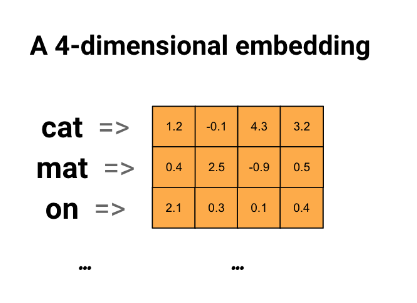

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 641,057
Trainable params: 641,057
Non-trainable params: 0
__________________________________________________

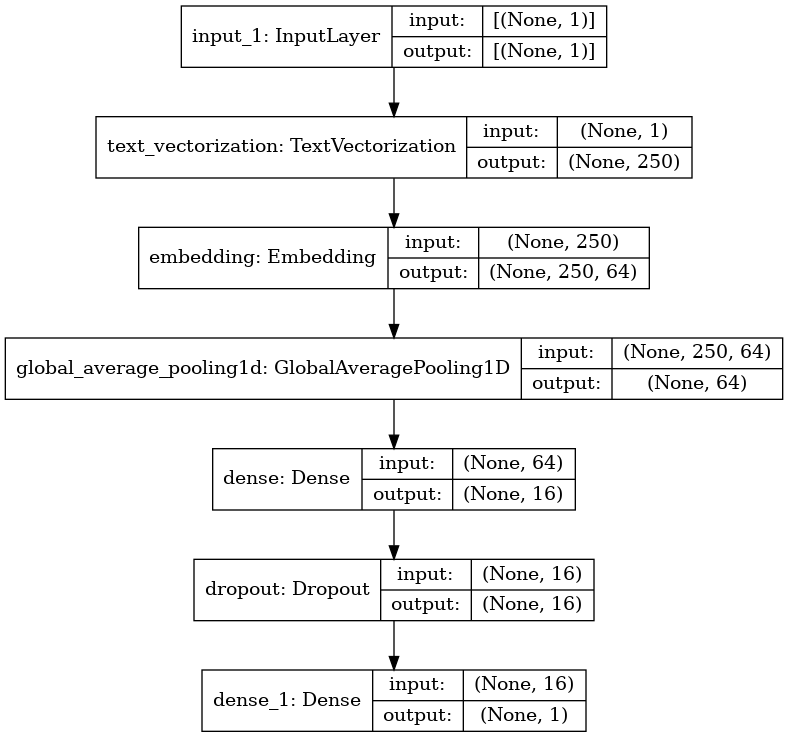

In [8]:
plot_model(model, show_shapes=True)

In [9]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

🔍 **Due to our last Dense Layer has a linear activation function, it computes the logits. So the loss function needs to be computed with `from_logits=True`.**

In this case, I will use [EarlyStopping Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to avoid overfitting. 

[Click Here to learn more about Early Stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/)

In [10]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback])

Epoch 1/100
191/191 [==============================] - 3s 10ms/step - loss: 0.6815 - binary_accuracy: 0.5732 - val_loss: 0.6823 - val_binary_accuracy: 0.5588
Epoch 2/100
191/191 [==============================] - 2s 8ms/step - loss: 0.6720 - binary_accuracy: 0.5732 - val_loss: 0.6682 - val_binary_accuracy: 0.5588
Epoch 3/100
191/191 [==============================] - 2s 8ms/step - loss: 0.6303 - binary_accuracy: 0.5772 - val_loss: 0.5971 - val_binary_accuracy: 0.5929
Epoch 4/100
191/191 [==============================] - 2s 8ms/step - loss: 0.5252 - binary_accuracy: 0.6987 - val_loss: 0.5087 - val_binary_accuracy: 0.7682
Epoch 5/100
191/191 [==============================] - 2s 9ms/step - loss: 0.4301 - binary_accuracy: 0.7957 - val_loss: 0.4672 - val_binary_accuracy: 0.7840
Epoch 6/100
191/191 [==============================] - 1s 8ms/step - loss: 0.3725 - binary_accuracy: 0.8350 - val_loss: 0.4521 - val_binary_accuracy: 0.7892
Epoch 7/100
191/191 [==============================] - 2s

🙉 **It looks like the NN learn a lot more! Val Accuracy of 0.8**

## Predict Test

In [11]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [12]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
preds = model.predict(topred_ds)

In [14]:
preds

array([[1.626427 ],
       [0.6582693],
       [5.033337 ],
       ...,
       [2.6492274],
       [2.4858732],
       [1.0287898]], dtype=float32)

In [15]:
tf.nn.sigmoid(preds)

<tf.Tensor: shape=(3263, 1), dtype=float32, numpy=
array([[0.8356796 ],
       [0.6588715 ],
       [0.9935252 ],
       ...,
       [0.9339634 ],
       [0.92314553],
       [0.73668116]], dtype=float32)>

In [16]:
test_df["target"] = tf.round(tf.nn.sigmoid(preds))
test_df["target"] = test_df["target"].astype(int)

In [17]:
test_df

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [18]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [19]:
sub.to_csv("Embedding_submission.csv", index = False)

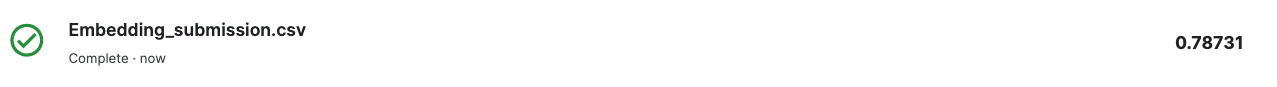

# Pre-trained Embeddings

We just use our own embedding wich was fitted to data. Now we will leverage some pretrained Embeddings. That is basically we will not start from random numbers in the embeddin matrix, but with numbers trained in large corpus of data! We can choose fine-tune these pretrained embeddings or just freeze them!

There a lot of pretrained Embeddings, the most common are:
1. GloVe
2. Word2Vec

Each of these pre-trained Embeddings has different sizes (dimensions). It is up to us!

## GloVe

It is important to know how (and on what data) this embedding was trained. Here are some references:

- https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010
- https://nlp.stanford.edu/projects/glove/


In [20]:
# First we download the embedding or matrix !
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-12 01:05:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-12 01:05:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-12 01:05:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

👀👀👀👀👀👀👀👀👀

We will use the same Tensorflow Embedding layer. For this we need to construct an embedding matrix and initialize the layer with that matrix.

To do that we will:

1. Create the embedding index. i.e From the txt embedding file we will get the representation vector for each word! (token)
2. We will assign the pre-trained representation vector to each word(token) of our vocabulary. If the word is not in the pre-trained embedding, we will let a zeros vector
3. In the model we initialize the layer with our pre-trained embedding matrix

So we will get an embedding matrix of shape (voc_size, embedding_size). Note that each index corresponds to a specific word of our vocabulary. So we need to map index -> embedding.

In [21]:
import os

# Create a pre-trained embedding index

path_to_glove_file = './glove.6B.50d.txt' # We can choose 300d,200d,100d,50d

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [22]:
# Word index of OUR vocabulary
voc = vectorization_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [23]:
#word_index

In [24]:
# We have to construct the embedding matrix with weigths from our own vocabulary

# shape embedding matrix : (vocab_size, embedding_dim)
num_tokens = len(voc)
embedding_dim = 50 # we download glove 100 dimension
hits = []
misses = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits.append(word)
    else:
        misses.append(word)
print("Converted %d words (%d misses)" % (len(hits), len(misses)))

Converted 7692 words (2308 misses)


## Model

The same architecture as above but now with the GloVe pre-trained embedding

In [25]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True), # To Fine tune
    layers.GlobalAveragePooling1D(),
    layers.Dense(16),
    layers.Dropout(0.3),
    layers.Dense(1)
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 50)           500000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 500,833
Trainable params: 500,833
Non-trainable params: 0
________________________________________________

In [27]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [28]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback])

Epoch 1/100
191/191 [==============================] - 3s 9ms/step - loss: 0.6637 - binary_accuracy: 0.5732 - val_loss: 0.6411 - val_binary_accuracy: 0.5588
Epoch 2/100
191/191 [==============================] - 1s 8ms/step - loss: 0.5936 - binary_accuracy: 0.6099 - val_loss: 0.5518 - val_binary_accuracy: 0.6717
Epoch 3/100
191/191 [==============================] - 1s 8ms/step - loss: 0.5024 - binary_accuracy: 0.7402 - val_loss: 0.4895 - val_binary_accuracy: 0.7879
Epoch 4/100
191/191 [==============================] - 1s 7ms/step - loss: 0.4393 - binary_accuracy: 0.7924 - val_loss: 0.4594 - val_binary_accuracy: 0.7984
Epoch 5/100
191/191 [==============================] - 1s 7ms/step - loss: 0.3949 - binary_accuracy: 0.8202 - val_loss: 0.4412 - val_binary_accuracy: 0.8050
Epoch 6/100
191/191 [==============================] - 2s 9ms/step - loss: 0.3598 - binary_accuracy: 0.8415 - val_loss: 0.4314 - val_binary_accuracy: 0.8089
Epoch 7/100
191/191 [==============================] - 2s 

## Predict Test

In [29]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [30]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
preds = model.predict(topred_ds)

In [32]:
preds

array([[1.5487207],
       [1.0597007],
       [3.9148426],
       ...,
       [1.958971 ],
       [2.308964 ],
       [1.0568069]], dtype=float32)

In [33]:
tf.nn.sigmoid(preds)

<tf.Tensor: shape=(3263, 1), dtype=float32, numpy=
array([[0.8247289 ],
       [0.74263334],
       [0.98044634],
       ...,
       [0.8764216 ],
       [0.9096167 ],
       [0.74207985]], dtype=float32)>

In [34]:
test_df["target"] = tf.round(tf.nn.sigmoid(preds))
test_df["target"] = test_df["target"].astype(int)

In [35]:
test_df

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [36]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [37]:
sub.to_csv("GloVe_Embedding_submission.csv", index = False)

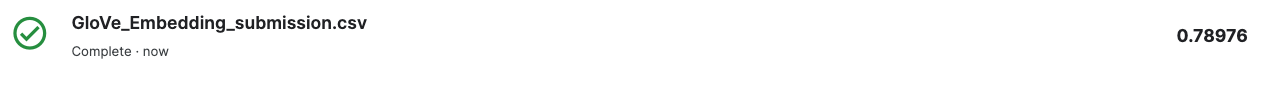

🥰🥰🥰🥰🥰🥰

**Yes! We improve the score! Although it is not so much better. I think that means that is not to difficult learn the embedding from scratch in this use case! Maybe due we have enough data? or because we select a not to huge embedding dimension? What do you think?**

> 🧠 Task: Try with an 300,200 or 100 d Glove Embedding!

# Twitter Embedding

I want to test a embedding trained on twitter data. I expected that it could incorporate things like hashtags(#), at(@), etc.

Navigating trough internet I found this: https://github.com/FredericGodin/TwitterEmbeddings

It actually has a dataset on Kaggle, so I add it to the notebook! You can find it As: 

/kaggle/input/twitter-word2vecs-wordvecs-from-godin

It has different algorithms like Fasttext, Word2Vec, etc. I will use Word2Vec but you are free to choose whatever you want

In [38]:
# We will use Keyedvector from gensim (https://radimrehurek.com/gensim/models/keyedvectors.html)
wv = KeyedVectors.load_word2vec_format('../input/twitter-word2vecs-wordvecs-from-godin/word2vec_twitter_tokens.bin', 
                                       binary=True,
                                       unicode_errors='ignore')


In [39]:
# Test most similar 
wv.most_similar('earthquake')

[('Earthquake', 0.7484592199325562),
 ('quake', 0.7243907451629639),
 ('#earthquake', 0.6934228539466858),
 ('#Earthquake', 0.6418332457542419),
 ('earthquakes', 0.6231516599655151),
 ('tornado', 0.5646125674247742),
 ('tsunami', 0.5609468817710876),
 ('aftershock', 0.5554280281066895),
 ('earthquak', 0.5473548769950867),
 ('explosion', 0.5468594431877136)]

In [40]:
# dimension of embeddings 
len(wv["earthquake"])

400

As we did above, we need to build the embedding vectors

In [41]:
# Voc index
voc = vectorization_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


# We have to construct the embedding matrix with weigths from our own vocabulary
# shape embedding matrix : (vocab_size, embedding_dim)
num_tokens = len(voc)
embedding_dim = 400 # we download word2vec 400d
hits = []
misses = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in wv:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_vector = wv[word]
        embedding_matrix[i] = embedding_vector
        hits.append(word)
    else:
        misses.append(word)
print("Converted %d words (%d misses)" % (len(hits), len(misses)))

Converted 7873 words (2127 misses)


In [42]:
embedding_matrix.shape

(10000, 400)

## Model

In [43]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True
    ),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16),
    layers.Dropout(0.3),
    layers.Dense(1)
])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 250, 400)          4000000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 4,006,433
Trainable params: 4,006,433
Non-trainable params: 0
____________________________________________

In [45]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [46]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback])

Epoch 1/100
191/191 [==============================] - 9s 39ms/step - loss: 0.6561 - binary_accuracy: 0.5745 - val_loss: 0.6037 - val_binary_accuracy: 0.6179
Epoch 2/100
191/191 [==============================] - 7s 37ms/step - loss: 0.5149 - binary_accuracy: 0.7233 - val_loss: 0.4822 - val_binary_accuracy: 0.7439
Epoch 3/100
191/191 [==============================] - 7s 39ms/step - loss: 0.3944 - binary_accuracy: 0.8220 - val_loss: 0.4769 - val_binary_accuracy: 0.7663
Epoch 4/100
191/191 [==============================] - 7s 37ms/step - loss: 0.3212 - binary_accuracy: 0.8614 - val_loss: 0.4878 - val_binary_accuracy: 0.7827
Epoch 5/100
191/191 [==============================] - 7s 38ms/step - loss: 0.2681 - binary_accuracy: 0.8854 - val_loss: 0.5148 - val_binary_accuracy: 0.7846
Epoch 6/100
191/191 [==============================] - 7s 37ms/step - loss: 0.2223 - binary_accuracy: 0.9080 - val_loss: 0.5104 - val_binary_accuracy: 0.7965
Epoch 7/100
191/191 [==============================]

## Predict Test

In [47]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [48]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
preds = model.predict(topred_ds)

In [50]:
preds

array([[-0.06506764],
       [ 0.26650202],
       [ 5.848435  ],
       ...,
       [ 1.5803046 ],
       [ 1.5205853 ],
       [ 0.33927795]], dtype=float32)

In [51]:
tf.nn.sigmoid(preds)

<tf.Tensor: shape=(3263, 1), dtype=float32, numpy=
array([[0.48373884],
       [0.56623393],
       [0.9971239 ],
       ...,
       [0.8292477 ],
       [0.82062465],
       [0.58401513]], dtype=float32)>

In [52]:
test_df["target"] = tf.round(tf.nn.sigmoid(preds))
test_df["target"] = test_df["target"].astype(int)

In [53]:
test_df

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1


In [54]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [55]:
#sub.to_csv("TTW2V_Embedding_Submission.csv", index = False)
sub.to_csv("submission.csv", index = False)

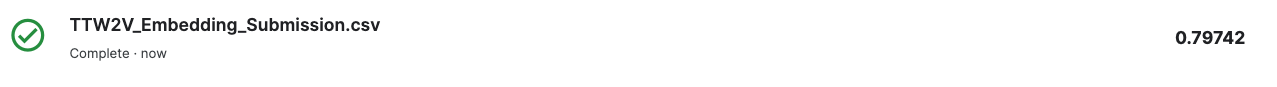

Nice! As we excpected it, We improve the score a little bit!

# Conclusions

We had improved our score from 0.56 to 0.79 (That's very good). We are learning a lot!

Embeddings solve the problem of have a good representation of text! But we still having some other problems:

- The input of the Dense layers could vary in size! There are sequences of differents size! (Remember that we solve it with padding and truncation)
- Due to sequences could be large, there is a lot of computational costs!
- Layers are not sharing information! (They have different weighths) So we are not takin account the order of the words, the context, or the words around

To take care of this points, we will apply Recurrent Neural Networks in the next notebook! 💥💥💥💥

# References:

- [Understanding Embeddings](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce)
- [CodeBasics Embeddings Explanation](https://www.youtube.com/watch?v=sZGuyTLjsco)
